In [143]:
import pandas_ta as ta
import pandas as pd
import yfinance as yf
import mplfinance as mpf

In [144]:
df = pd.DataFrame().ta.ticker("TSLA")

c:\Users\Arnas Vaicekauskas\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [145]:
short_window = 10
long_window = 20

df['sma-short'] = df['Close'].rolling(window=short_window).mean()
df['sma-long'] = df['Close'].rolling(window=long_window).mean()

df['signal'] = 0
df.loc[df['sma-short'] > df['sma-long'], 'signal'] = 1
df.loc[df['sma-short'] < df['sma-long'], 'signal'] = -1

df['dsignal'] = df['signal'].diff()

In [146]:
# take some interval
start_date, end_date = '2023-01-01', '2023-03-31'

df = df[df.index >= start_date]
df = df[df.index <= end_date]

In [147]:
df['dsignal']

Date
2023-01-03 00:00:00-05:00    0.0
2023-01-04 00:00:00-05:00    0.0
2023-01-05 00:00:00-05:00    0.0
2023-01-06 00:00:00-05:00    0.0
2023-01-09 00:00:00-05:00    0.0
                            ... 
2023-03-27 00:00:00-04:00    0.0
2023-03-28 00:00:00-04:00    2.0
2023-03-29 00:00:00-04:00    0.0
2023-03-30 00:00:00-04:00    0.0
2023-03-31 00:00:00-04:00    0.0
Name: dsignal, Length: 62, dtype: float64

In [148]:
offset = 10

# zero everywhere, except where buy action happened
df['buy_action'] = None
df.loc[df['dsignal'] > 0, 'buy_action'] = df['sma-short']

# zero everywhere, except where sell action happened
df['sell_action'] = None
df.loc[df['dsignal'] < 0, 'sell_action'] = df['sma-short']

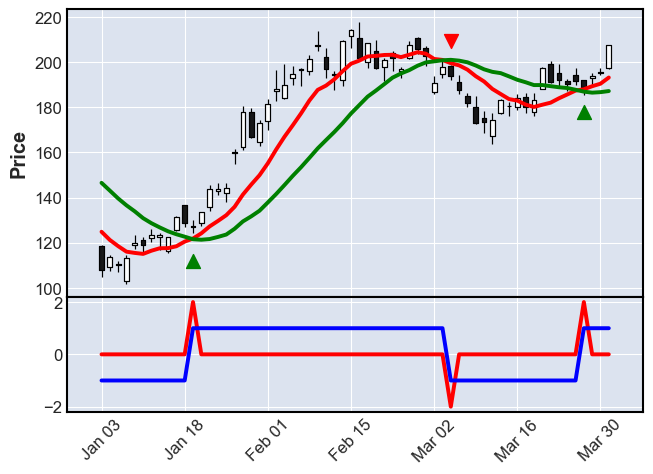

In [151]:
apds = [
    mpf.make_addplot(df['buy_action'] - offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='^', color = 'green'),
    mpf.make_addplot(df['sell_action'] + offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='v', color = 'red'),
    mpf.make_addplot(df['dsignal'], panel=1, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-short'], panel=0, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-long'], panel=0, color='g', secondary_y=False),
    mpf.make_addplot(df['signal'], panel=1, color='b', secondary_y=False)
]

# markers={'markers': [(buy_signals.index, buy_signals['Close'], '^', 100), (sell_signals.index, sell_signals['Close'], 'v', 100)]}
mpf.plot(df, type='candle', addplot=apds, volume=False)

In [150]:
signal = []